## Markov chain Monte Carlo (MCMC)

In simple Bayesian problems with a small number of parameters, it is possible to compute the exact form of the posterior distribution, but in the real problems due to a large number of parameters, calculations get complicated. MCMC is the class of algorithms for sampling from a probability distribution (e.g. posterior). In other words, we want to sample the probability distribution such that the chance of sampling each point is proportional to the true distribution.  

Let's look into a very simple example. Imagine that the weather condition (Sunny(S) or Rainy(R)) of day n only depends on the weather condition of day n-1. And also the following conditional probabilities are given: 

$$P(S_{n+1}|S_{n})=90\%$$

$$P(R_{n+1}|S_{n})=10\%$$

$$P(S_{n+1}|R_{n})=50\%$$

$$P(R_{n+1}|R_{n})=50\%$$

We want to find the probability of sunny and rainy weather. If you remember the linear algebra part of the course and our example in session 2, given the initial state of the system $[S\ \ R]$ (for example $[1\ \ 0]$ for sunny day) then the prediction for next day is:

\begin{equation*}
\begin{bmatrix}
0.9&0.5\\
0.1&0.5\\
\end{bmatrix}
\begin{bmatrix}
1\\
0\\
\end{bmatrix}=
\begin{bmatrix}
0.9\\
0.1\\
\end{bmatrix}
\end{equation*}

And the final state regardless of initial condition converges to the eigenvector (X) of transition matrix: 

\begin{equation*}
\begin{bmatrix}
0.9&0.5\\
0.1&0.5\\
\end{bmatrix}
X=X
\end{equation*}

Finding eigenvector we know that the probability of sunny weather regardless of the initial condition is 83.3% and rainy weather is 16.6%.

In [1]:
import numpy as np

In [7]:
T=np.array([[0.9,0.5],[0.1,0.5]])
Eigenvector=np.linalg.eig(T)[1][:,0]

In [10]:
Eigenvector/Eigenvector.sum()

array([0.83333333, 0.16666667])

Use MCMC to solve the problem. Consider an initial weather condition. For example Sunny (S), then generate a random uniform number between 0 and 1, if the number less than 0.9, stay at the same state "S", otherwise jump to "R". If you are on "R" state, if the number is less than 0.5, stay at "R", otherwise jump to "S". Repeat the procedure for a large number of times and then the fraction of "R" shows the probability of rainy and the fraction of "S" shows the probability of sunny weather.

In [18]:
def State(State_i):
    rand=np.random.rand()
    if State_i=="S":
        if rand>0.9:
            State_f="R"
        else:
            State_f="S"
    if State_i=="R":
        if rand>0.5:
            State_f="S"
        else:
            State_f="R"
    return(State_f)

In [19]:
Outcome=['S']

In [20]:
for N in range(10000):
    Outcome.append(State(Outcome[-1]))

In [26]:
PS=Outcome.count('S')/len(Outcome)
print(PS)

0.8378162183781622


In [27]:
PR=Outcome.count('R')/len(Outcome)
print(PR)

0.1621837816218378


Let's look at the specific implementation of MCMC: Metropolis-Hastings. The algorithm is as follows:

1) Initialize all the variables ($\theta$) and number of iterations (n)

#### For n iterations:

2) Find the posterior at point $\theta$  
3) Define a reasonable function to move from point $\theta$ to $\theta'$  
4) Find $r=\frac{\text{Posterior}(\theta')}{\text{Posterior}(\theta)}$  
5) Generate a uniform random number ($rand$) between 0 and 1.   
6) if  $r>rand$ ; then move to new point $\theta'$, otherwise, stay in the same point $\theta$  


Use MCMC to solve the problem of homework 2 (twitter problem). Feel free to use codes below for HW3.

In [54]:
def MCMC(log_Posterior,data,initial,step_cov,n_iteration):
    param1=np.array(initial)
    sample=np.array(initial)
    for j in range(n_iteration):
        log_Posterior_i=log_Posterior(data,param1)
        #update the location
        param2=np.random.multivariate_normal(param1,step_cov)
        #find new posterior
        log_Posterior_f=log_Posterior(data,param2)
        # generate a random number between 0 and 1
        rand=np.random.rand()
        if log_Posterior_f-log_Posterior_i>np.log(rand):
            sample=np.vstack((sample,param2))
            param1=param2[:]
        else:
            sample=np.vstack((sample,param1))
    return(sample)    

In [55]:
import pandas as pd

data=pd.read_csv('../Homework/tweet_counts.csv')
data.head()

,week,count
0,1,39.0
1,2,46.0
2,3,41.0
3,4,42.0
4,5,31.0


In [56]:
k=data['count'].values
w=data['week'].values

In [57]:
Poisson=lambda k,λ : (λ**k)/np.math.factorial(k)*np.exp(-λ)

In [58]:
α=1/np.mean(k)

In [59]:
def log_posterior(data,param):
    k,w=data
    lamb1,lamb2,W_s=param
    
    P=0
    
    for i in k[w<W_s]:
        P=P+np.log(Poisson(i,lamb1)*α*np.exp(-α*lamb1))

    for j in k[w>=W_s]:
        P=P+np.log(Poisson(j,lamb2)*α*np.exp(-α*lamb2))
        
    return(P)

In [61]:
D=MCMC(log_posterior,data=[k,w],initial=[20,20,20],step_cov=[[0.25,0,0],[0,0.25,0],[0,0,0.5]],n_iteration=10000)

In [63]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize']=8,6

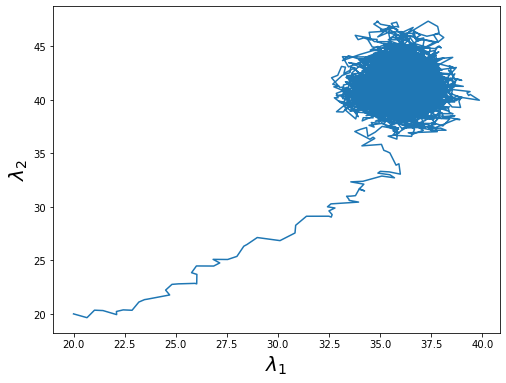

In [68]:
plt.plot(D.T[0],D.T[1])
plt.xlabel("$\lambda_1$",fontsize=20)
plt.xlabel("$\lambda_1$",fontsize=20)
plt.ylabel("$\lambda_2$",fontsize=20)

plt.show()

Let's remove the first iterations where we search low-probability regions

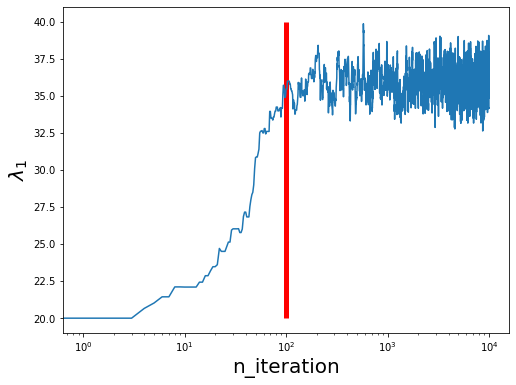

In [71]:
plt.plot(D.T[0])
plt.ylabel("$\lambda_1$",fontsize=20)
plt.xlabel("n_iteration",fontsize=20)
plt.vlines(100,20,40,color='red',linewidth=5)
plt.xscale('log')

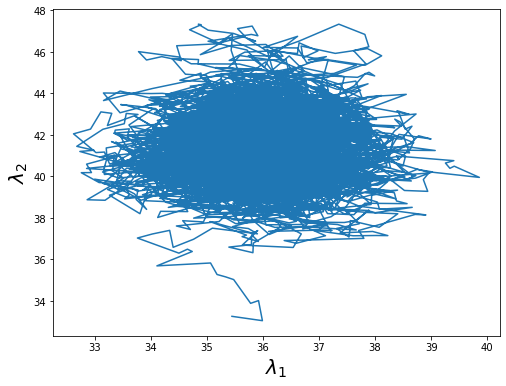

In [72]:
plt.plot(D.T[0][100:],D.T[1][100:])
plt.xlabel("$\lambda_1$",fontsize=20)
plt.xlabel("$\lambda_1$",fontsize=20)
plt.ylabel("$\lambda_2$",fontsize=20)

plt.show()

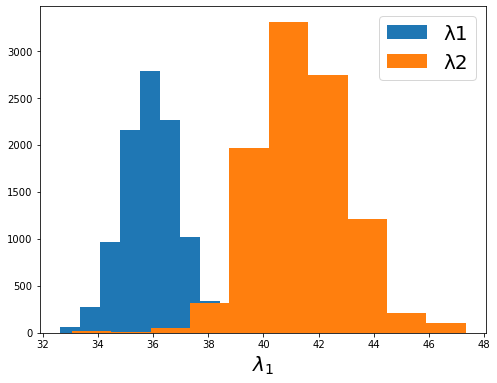

In [73]:
plt.hist(D.T[0][100:],label='λ1')
plt.hist(D.T[1][100:],label='λ2')
plt.xlabel("$\lambda_1$",fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [75]:
print('mean(λ1 is)',np.mean(D.T[0][100:]))
print('std(λ1 is)',np.std(D.T[0][100:]))

mean(λ1 is) 35.91329155784873
std(λ1 is) 0.9997899366620614


In [76]:
print('mean(λ2 is)',np.mean(D.T[1][100:]))
print('std(λ2 is)',np.std(D.T[1][100:]))

mean(λ2 is) 41.38055662825337
std(λ2 is) 1.635416266179648


In [78]:
print('mean(W_s is)',np.round(np.mean(D.T[2][100:])))

mean(W_s is) 34.0
